In [ ]:
%%capture
!pip install yfinance
!pip install mplfinance
!pip install fyers-apiv2

### **Fyers Authentication**
**All the required parameters for creating auth_code are stored in the fyers_secret.txt file in the given order.That is client id in first line followed by secret_key in next line and so on**

In [ ]:
# Using readlines()
file1 = open('/content/drive/MyDrive/fyers_secret.txt', 'r')
Lines = file1.readlines()
client_id = Lines[0][0:-1]
secret_key = Lines[1][0:-1]
redirect_uri = Lines[2][0:-1]
response_type = Lines[3][0:-1]
grant_type = Lines[4][0:-1]
state = Lines[5]
# Strips the newline character
state

'success'

In [ ]:
from fyers_api import fyersModel
from fyers_api import accessToken
#import asyncio
from concurrent import futures
session=accessToken.SessionModel(client_id=client_id,
secret_key=secret_key,redirect_uri=redirect_uri, 
response_type=response_type, grant_type=grant_type,
state=state)

response = session.generate_authcode()  
#response

In [ ]:
#auth_code = ""
session.set_token(auth_code)
response = session.generate_token()
access_token = response["access_token"]
log_path = "/content/drive/MyDrive/Fyers_logs"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token,log_path=log_path)
is_async = True  #(By default the async will be False, Change to True for async API calls.)



In [ ]:
data = {"symbols":"NSE:TCS-EQ"}
o = fyers.quotes(data) #['d'][0].get('v').get('cmd').get('o')
o

## **Support Line detector**
####**Parameters to be editted by user: symbol, resolution, range_from,range_to**
####**Functions used are:** 
####**(1) data_input():**
####    **INPUT: ticker(input for this: symbol, resolution, range_from, range_to)**
####   **OUTPUT: data of past 100 candlesticks**
####**(2) plot_ohlc(): Plots the past 100 candlesticks and the support line if it's unbroken, else it only plots the candlesticks.**
####**(3) draw_trend_line(): Returns the corresponding y-axis points for the angle input.**
####**(4) check_trendline(): Checks if the support line is unbroken and outputs the unbroken support lines corresponding to various angles (from 0 degrees to 70 degrees)**

####**FINALLY:**
####**The above functions are run at the end to produce the support line(if it exists/unbroken) and the candlesticks plot, this final cell is run every 'interv' seconds where 'interv' equals the interval of the data thus facilitating real time updation**

####**Flow of the program is as follows:**
####**data_input() ---> (draw_trend_lines() - run inside check_trend_lines())--->check_trend_lines()--->plot_ohlc()[looped through different angles producing plots corresponding to different angles] ---> Sleep for interv seconds ---> Re-run**


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import time
import math
import mplfinance as mpf
from IPython.display import clear_output 
import warnings
import datetime
import pytz 

In [ ]:
#User should only edit these 4 parameters
######################################################################

symbol = "NSE:CANFINHOME-EQ" 
resolution = "1" # 1 for 1 min, 2 for 2 min, and so on for 3,5,10,15,30,60,120,240
range_from = "2022-06-01" #YYYY-MM-DD
range_to = "2022-06-01" #YYYY-MM-DD

######################################################################

ticker = {"symbol":symbol,"resolution":resolution,"date_format":"1","range_from": range_from,"range_to": range_to,"cont_flag":"1"}

In [ ]:
def data_input(ticker):
  """data = yf.download(tickers=ticker, period=period, interval=interval)"""

  ss = fyers.history(ticker)['candles']
  for i in range(len(ss)):
    ss[i][0] = ss[i][0] + 19800 #The datetime given is the unix time format which is 5hr30min slower than IST hence add (5*3600)+(30*60) = 19800
  if(ss[-1][5]==0): ss=ss[:-1] #In order to remove junk values at the end
  data = pd.DataFrame(data=ss,columns=['Date', 'Open','High','Low','Close','Volume'])
  data['Date'] =[ time.strftime("%Y-%m-%d, %H:%M",time.localtime(float(x))) for x in data['Date']]
  data['Date'] = pd.to_datetime(data['Date'])
  #data['Date'] = datetime.datetime.fromtimestamp(data['Date']) 
  #data = data[::-1] 
  data = data.set_index('Date')

  data = data[-150:]
  data['min_price'] = np.nan
  #data = data.reset_index(drop = False)
  for i in range(len(data)):
    if (data['Open'].iloc[i]<data['Close'].iloc[i]):
      s = 'Open'
    else:
      s = 'Close'
    data['min_price'].iloc[i] = data[s].iloc[i]  
  return data

In [ ]:
def plot_ohlc(lines_x1,lines_y1,j=9):
  if(len(lines_y1)>0):
    multiple_points_arr = []
    for i in range(len(lines_y1)):
      multiple_points = np.array(list(zip(lines_x1,lines_y1[i])))
      multiple_points = multiple_points.tolist()
      multiple_points_arr.append(multiple_points)
      #volumeAxes.set_ylim(vymin() - 0.5, vymax() + 0.5)
    mpf.plot(data, figratio=(8,4), type='candle',alines = multiple_points_arr[j], volume=True, style='yahoo')
  else:
    mpf.plot(data, figratio=(8,4), type='candle', volume=True, style='yahoo')
  #mpf.plot(data, figratio=(8,4), type='candle',alines = multiple_points_arr[10], volume=True, style='yahoo')

In [ ]:
def draw_trend_line(angle,data):
  data = data.reset_index(drop = False)
  min_index = data['min_price'].idxmin()
  slope = math.tan(math.radians(angle))
  start_x = min_index
  start_y = data['min_price'][min_index]
  line_y = []
  for i in range(min_index,len(data)):
    y = start_y + (slope * list(data.index)[i-min_index])
    line_y.append(y)
  return line_y,min_index


In [ ]:
def check_trend_lines(data):
  lines_y = []
  angles_y = []
  angle = 0

  while (angle<=70):
    line_y,min_index = draw_trend_line(angle,data)
    count = 0
    deny_line = 0
    for j in range(min_index+1,len(data)):
      #This piece of code eliminates higher angles
      if((float(line_y[j-min_index])>float(data['Close'].iloc[j]))): #In order to eliminate those lines which are broken by red candle sticks which close below the trendline
        deny_line +=1
        break
    if(deny_line==0):
      for i in range(min_index+1,len(data)):
          if ((float(line_y[i-min_index])>=float(data['Low'].iloc[i])*0.999) and (float(line_y[i-min_index])<=float(data['min_price'].iloc[i])) ): #Detects those points of the trendline which lie between the Low and the min_price of the candlestick
            count = count + 1
    
    if (count >= 3):
        lines_y.append(line_y)
        angles_y.append(angle)
    angle = angle + 0.2
  lines_x = [data.index[i].to_pydatetime() for i in range(min_index,len(data))]
  for i in range(len(lines_x)):
    lines_x[i] = lines_x[i].replace (tzinfo=None)
  return lines_y,lines_x,angles_y

In [ ]:
if(resolution == '1'): interv = 60
if(resolution == '2'): interv = 120
if(resolution == '3'): interv = 180
if(resolution == '5'): interv = 300
if(resolution == '10'): interv = 600
if(resolution == '15'): interv = 900
if(resolution == '30'): interv = 1800
if(resolution == '60'): interv = 3600
if(resolution == '120'): interv = 7200
if(resolution == '240'): interv = 14400
 

The angle of the trendline is: 1.5999999999999999 deg


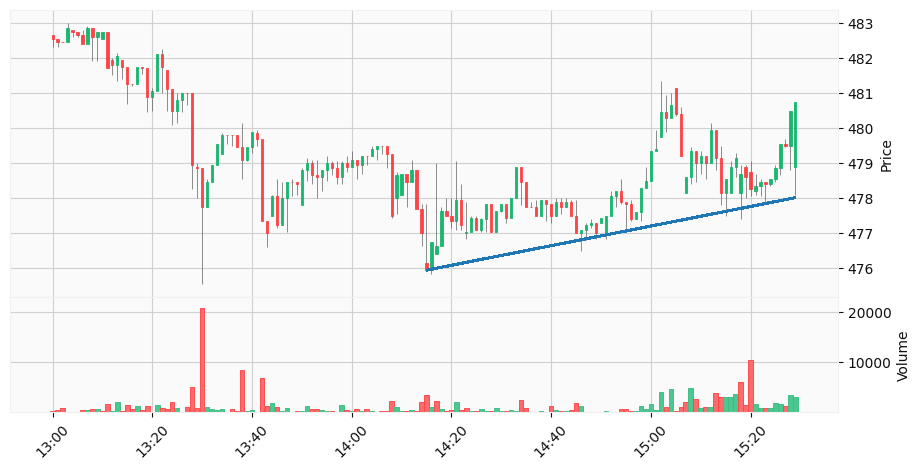

KeyboardInterrupt: ignored

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning) #ignore futurewarning
pd.options.mode.chained_assignment = None  # default='warn' #ignore copywarning
while(True):
  data = pd.DataFrame()
  data = data_input(ticker)
  lines_y1,lines_x1,angles = check_trend_lines(data)
  if(len(lines_y1)>0):
      """for i in range(len(lines_y1)):
      angle = angles[i]"""
      print("The angle of the trendline is: {} deg".format(angles[-1])) #Replace -1 with i for getting plots of all possible angles
      plot_ohlc(lines_x1,lines_y1,-1) #Replace -1 with i for getting plots of all possible angles
  else:
      print("No unbroken support line")
      plot_ohlc(lines_x1,lines_y1)
  time.sleep(interv)
  clear_output()